In [1]:
# Cell 1
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
import os
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import random
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

C:\Users\patri\AppData\Local\Temp\ipykernel_77456\2818129243.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)


Modified timestamps for file imputed_data.svc:
0      0
1    145
2    250
3    335
4    430
Name: timestamp, dtype: int32




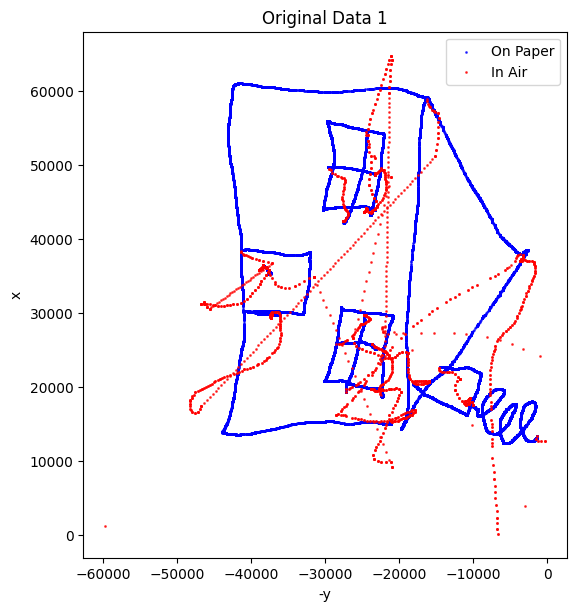

Number of processed files: 1
Average number of data points: 33854


In [2]:
# Cell 2
def upload_and_process_files(directory, num_files_to_use=None):
    svc_files = [f for f in os.listdir(directory) if f.endswith('.svc')]
    
    if num_files_to_use:
        svc_files = random.sample(svc_files, num_files_to_use)

    data_frames = []
    scalers = []

    num_files = len(svc_files)
    fig, axs = plt.subplots(1, num_files, figsize=(6*num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]

    for i, filename in enumerate(svc_files):
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        
        # Modify timestamp to start from 0
        df['timestamp'] = (df['timestamp'] - df['timestamp'].min()).round().astype(int)
        
        df = df.iloc[:, [0, 1, 2, 3]]  # Select x, y, timestamp, and pen_status
        data_frames.append(df)
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[['x', 'y', 'timestamp']])
        scalers.append(scaler)

        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]
        axs[i].scatter(-on_paper['y'], on_paper['x'], c='blue', s=1, alpha=0.7, label='On Paper')
        axs[i].scatter(-in_air['y'], in_air['x'], c='red', s=1, alpha=0.7, label='In Air')
        axs[i].set_title(f'Original Data {i + 1}')
        axs[i].set_xlabel('-y')
        axs[i].set_ylabel('x')
        axs[i].legend()
        axs[i].set_aspect('equal')

        # Print the first few rows of the timestamp column
        print(f"Modified timestamps for file {filename}:")
        print(df['timestamp'].head())
        print("\n")

    plt.show()

    processed_data = [np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                      for df, scaler in zip(data_frames, scalers)]
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, processed_data, scalers, avg_data_points

directory = '../uploads'  # Directory where the .svc files are stored
data_frames, processed_data, scalers, avg_data_points = upload_and_process_files(directory, num_files_to_use=1)
print(f"Number of processed files: {len(processed_data)}")
print(f"Average number of data points: {avg_data_points}")

In [3]:
# Cell 3 (modified)
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, beta=1.0):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.beta = beta
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(4,)),  # Changed to 4 for x, y, timestamp, pen_status
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(latent_dim * 2)
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(4)  # Changed to 4 for x, y, timestamp, pen_status
        ])

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        decoded = self.decoder(z)
        xy_timestamp = tf.sigmoid(decoded[:, :3])  # x, y, and timestamp
        pen_status = tf.sigmoid(decoded[:, 3])
        return tf.concat([xy_timestamp, tf.expand_dims(pen_status, -1)], axis=1)

    def call(self, inputs):
        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar


# New: LSTM Discriminator for GAN
class LSTMDiscriminator(tf.keras.Model):
    def __init__(self):
        super(LSTMDiscriminator, self).__init__()
        self.model = Sequential()
        self.model.add(LSTM(64, return_sequences=True, input_shape=(None, 4)))  # LSTM for sequence learning
        self.model.add(LSTM(32))
        self.model.add(Dense(1, activation='sigmoid'))  # Binary classification

    def call(self, x):
        return self.model(x)

# Function to compute VAE loss
def compute_loss(model, x):
    x_reconstructed, mean, logvar = model(x)
    reconstruction_loss_xy_timestamp = tf.reduce_mean(tf.keras.losses.mse(x[:, :3], x_reconstructed[:, :3]))
    reconstruction_loss_pen = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x[:, 3], x_reconstructed[:, 3]))
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))
    return reconstruction_loss_xy_timestamp + reconstruction_loss_pen, kl_loss, model.beta * kl_loss


latent_dim = 64
beta = 0.000001
learning_rate = 0.001

vae = VAE(latent_dim, beta)
optimizer = tf.keras.optimizers.Adam(learning_rate)


c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [4]:
# Cell 4 (modified)
def generate_augmented_data(model, num_augmented_files, avg_data_points, processed_data, variability=0.05, latent_variability=1.0):
    augmented_datasets = []
    num_input_files = len(processed_data)
    
    for i in range(num_augmented_files):
        # Select input data sequentially, cycling through if necessary
        selected_data = processed_data[i % num_input_files]
        
        mean, logvar = model.encode(tf.convert_to_tensor(selected_data, dtype=tf.float32))
        
        # Increase variability in the latent space
        z = model.reparameterize(mean, logvar * latent_variability)
        
        augmented_data = model.decode(z).numpy()

        # Post-process pen status
        augmented_data[:, 3] = post_process_pen_status(augmented_data[:, 3])
        
        # Ensure timestamps are in sequence
        augmented_data[:, 2] = np.sort(augmented_data[:, 2])
        
        augmented_datasets.append(augmented_data)

    return augmented_datasets

# The post_process_pen_status function remains unchanged
def post_process_pen_status(pen_status, threshold=0.5, min_segment_length=5):
    binary_pen_status = (pen_status > threshold).astype(int)
    
    # Smooth out rapid changes
    for i in range(len(binary_pen_status) - min_segment_length):
        if np.all(binary_pen_status[i:i+min_segment_length] == binary_pen_status[i]):
            binary_pen_status[i:i+min_segment_length] = binary_pen_status[i]
    
    return binary_pen_status

c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epoch 1/200: 100%|██████████| 529/529 [00:07<00:00, 70.38batch/s, Generator Loss=0.00436, Reconstruction Loss=0.00435, KL Loss=6.05] 


Epoch 1: Generator Loss = 0.072508, Reconstruction Loss = 0.072505, KL Divergence Loss = 3.111691
NRMSE = 0.224452


Epoch 2/200: 100%|██████████| 529/529 [00:02<00:00, 184.66batch/s, Generator Loss=0.00124, Reconstruction Loss=0.00123, KL Loss=8.89]  


Epoch 2: Generator Loss = 0.004923, Reconstruction Loss = 0.004916, KL Divergence Loss = 6.984931
NRMSE = 0.225972


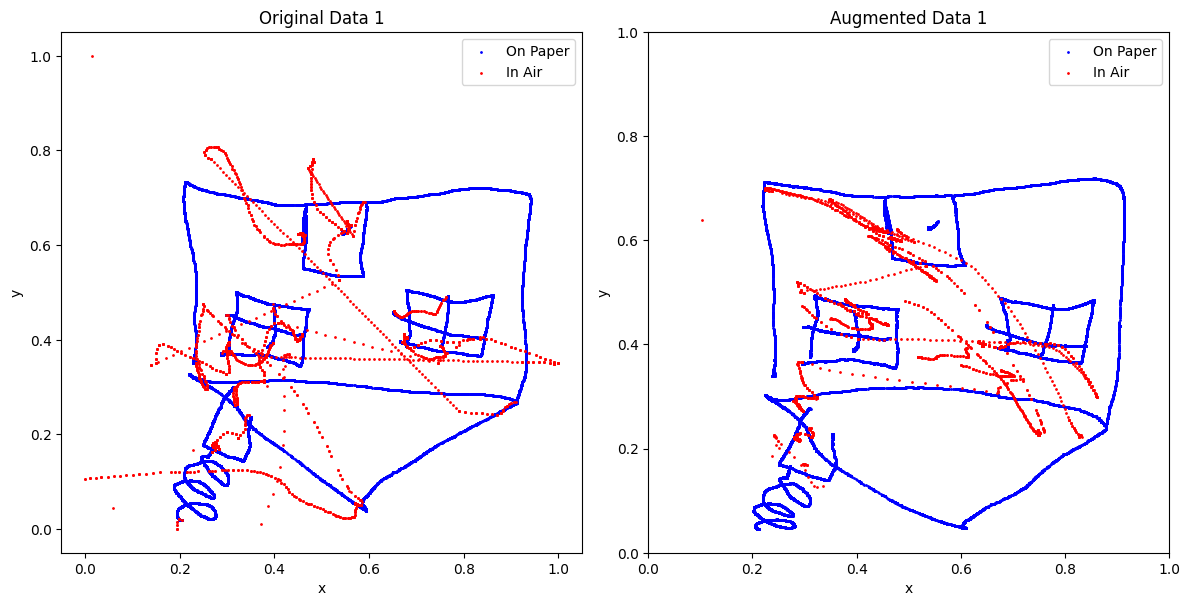

Epoch 3/200: 100%|██████████| 529/529 [00:02<00:00, 197.27batch/s, Generator Loss=0.000143, Reconstruction Loss=0.000133, KL Loss=9.72]


Epoch 3: Generator Loss = 0.000587, Reconstruction Loss = 0.000578, KL Divergence Loss = 9.305656
NRMSE = 0.228768


Epoch 4/200: 100%|██████████| 529/529 [00:02<00:00, 187.41batch/s, Generator Loss=0.00013, Reconstruction Loss=0.00012, KL Loss=9.89]  


Epoch 4: Generator Loss = 0.000200, Reconstruction Loss = 0.000190, KL Divergence Loss = 10.075613
NRMSE = 0.229676


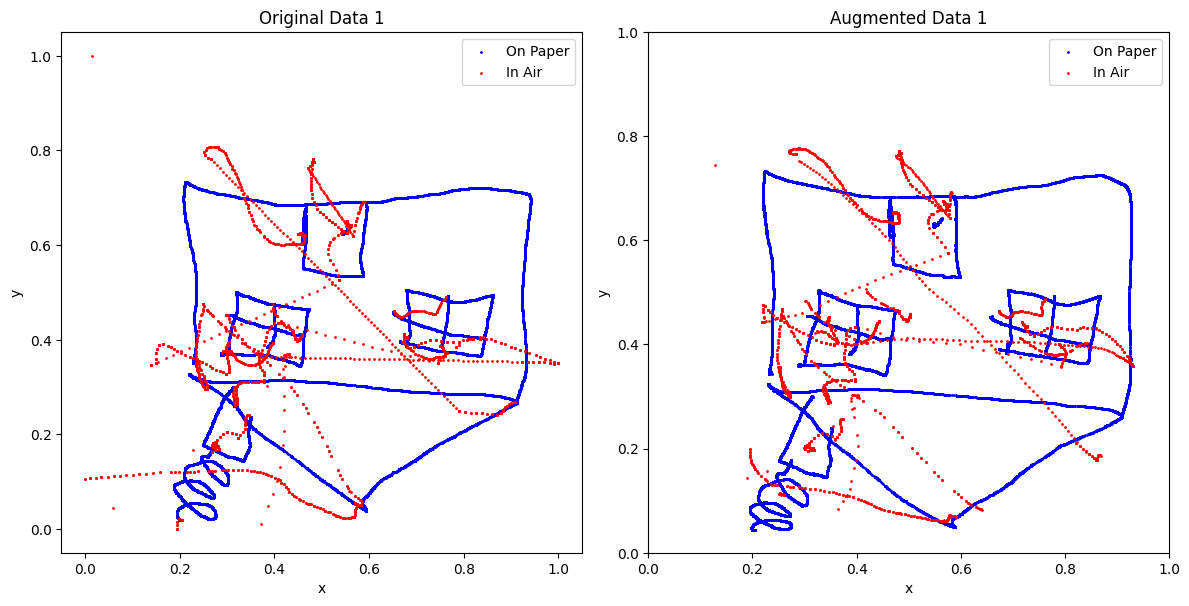

Epoch 5/200: 100%|██████████| 529/529 [00:03<00:00, 166.80batch/s, Generator Loss=7.82e-5, Reconstruction Loss=6.82e-5, KL Loss=9.96]  


Epoch 5: Generator Loss = 0.000130, Reconstruction Loss = 0.000120, KL Divergence Loss = 10.044509
NRMSE = 0.230404


Epoch 6/200: 100%|██████████| 529/529 [00:02<00:00, 213.71batch/s, Generator Loss=0.000288, Reconstruction Loss=0.000279, KL Loss=9.35]


Epoch 6: Generator Loss = 0.000118, Reconstruction Loss = 0.000108, KL Divergence Loss = 9.718336
NRMSE = 0.230943


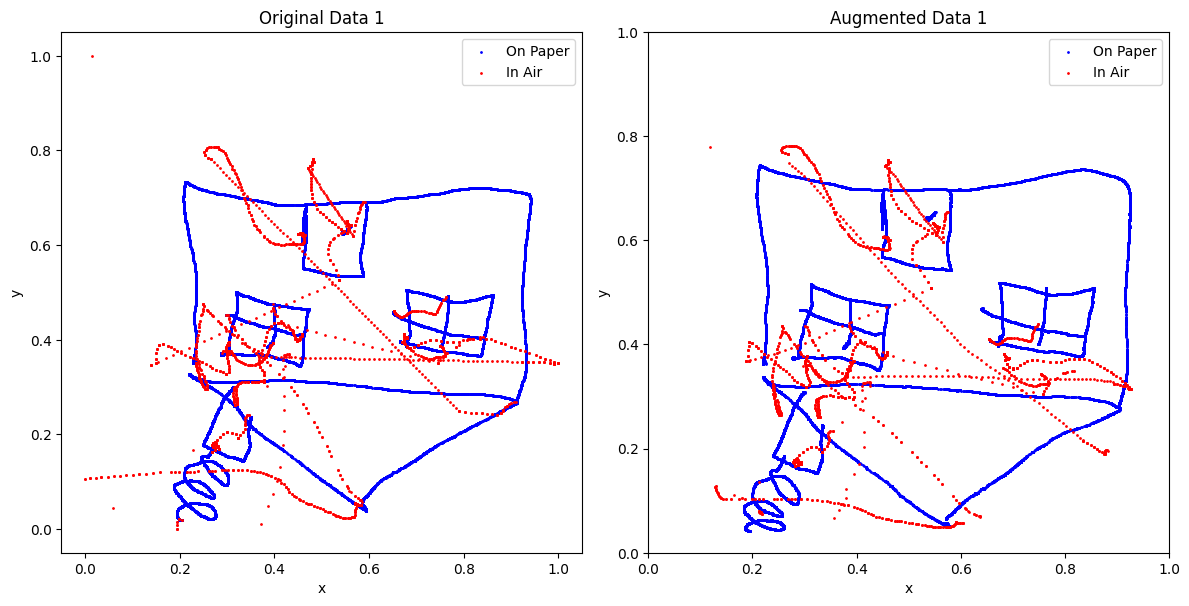

Epoch 7/200: 100%|██████████| 529/529 [00:02<00:00, 203.21batch/s, Generator Loss=5.77e-5, Reconstruction Loss=4.86e-5, KL Loss=9.13]  


Epoch 7: Generator Loss = 0.000109, Reconstruction Loss = 0.000099, KL Divergence Loss = 9.385080
NRMSE = 0.231243


Epoch 8/200: 100%|██████████| 529/529 [00:02<00:00, 205.34batch/s, Generator Loss=5.08e-5, Reconstruction Loss=4.27e-5, KL Loss=8.11]  


Epoch 8: Generator Loss = 0.000127, Reconstruction Loss = 0.000119, KL Divergence Loss = 8.897237
NRMSE = 0.231597


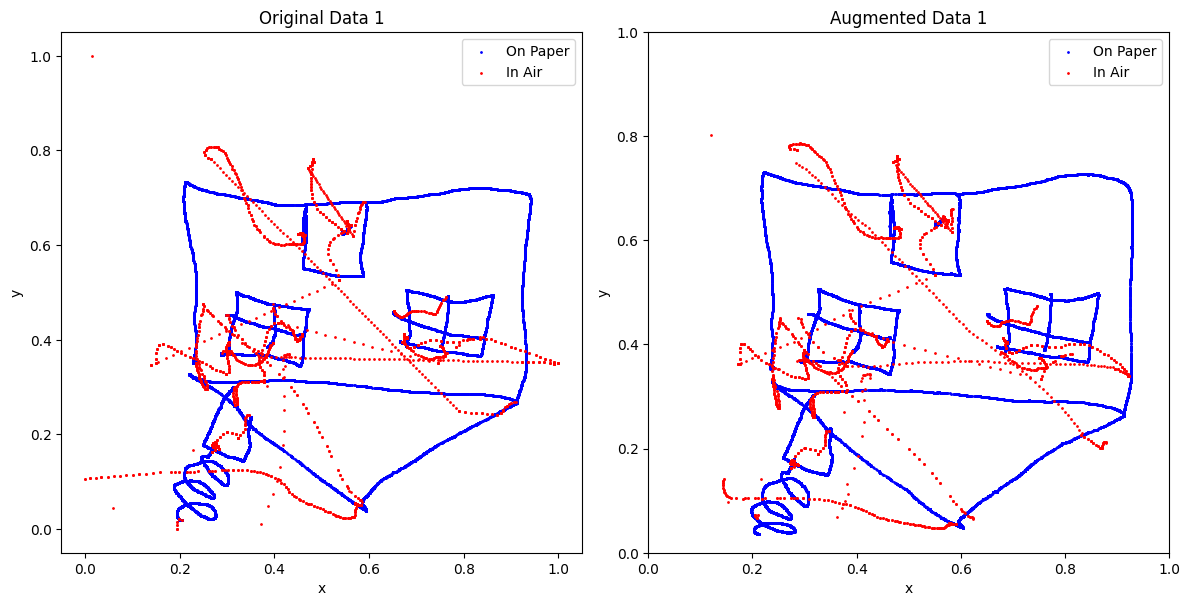

Epoch 9/200: 100%|██████████| 529/529 [00:02<00:00, 215.23batch/s, Generator Loss=0.000116, Reconstruction Loss=0.000108, KL Loss=8.06]


Epoch 9: Generator Loss = 0.000093, Reconstruction Loss = 0.000084, KL Divergence Loss = 8.588100
NRMSE = 0.232568


Epoch 10/200: 100%|██████████| 529/529 [00:02<00:00, 211.38batch/s, Generator Loss=6.18e-5, Reconstruction Loss=5.37e-5, KL Loss=8.12]  


Epoch 10: Generator Loss = 0.000084, Reconstruction Loss = 0.000075, KL Divergence Loss = 8.434952
NRMSE = 0.233140


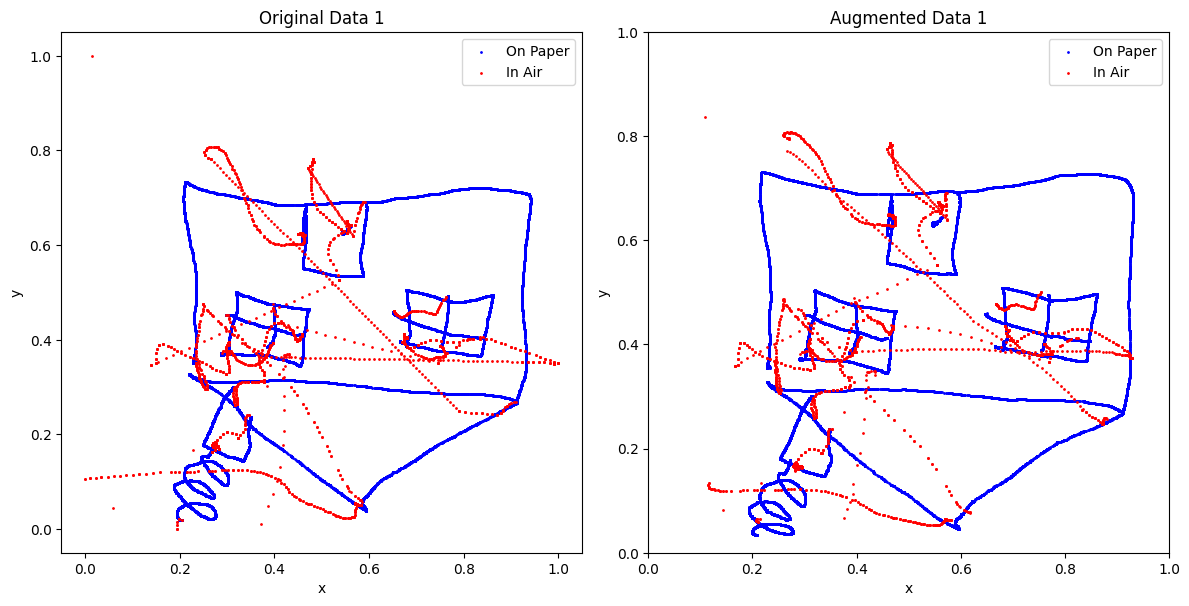

Epoch 11/200: 100%|██████████| 529/529 [00:02<00:00, 216.74batch/s, Generator Loss=0.000155, Reconstruction Loss=0.000148, KL Loss=7.51]


Epoch 11: Generator Loss = 0.000078, Reconstruction Loss = 0.000070, KL Divergence Loss = 8.145652
NRMSE = 0.233849


Epoch 12/200: 100%|██████████| 529/529 [00:02<00:00, 199.23batch/s, Generator Loss=9.7e-5, Reconstruction Loss=8.96e-5, KL Loss=7.41]   


Epoch 12: Generator Loss = 0.000075, Reconstruction Loss = 0.000067, KL Divergence Loss = 7.881785
NRMSE = 0.235225


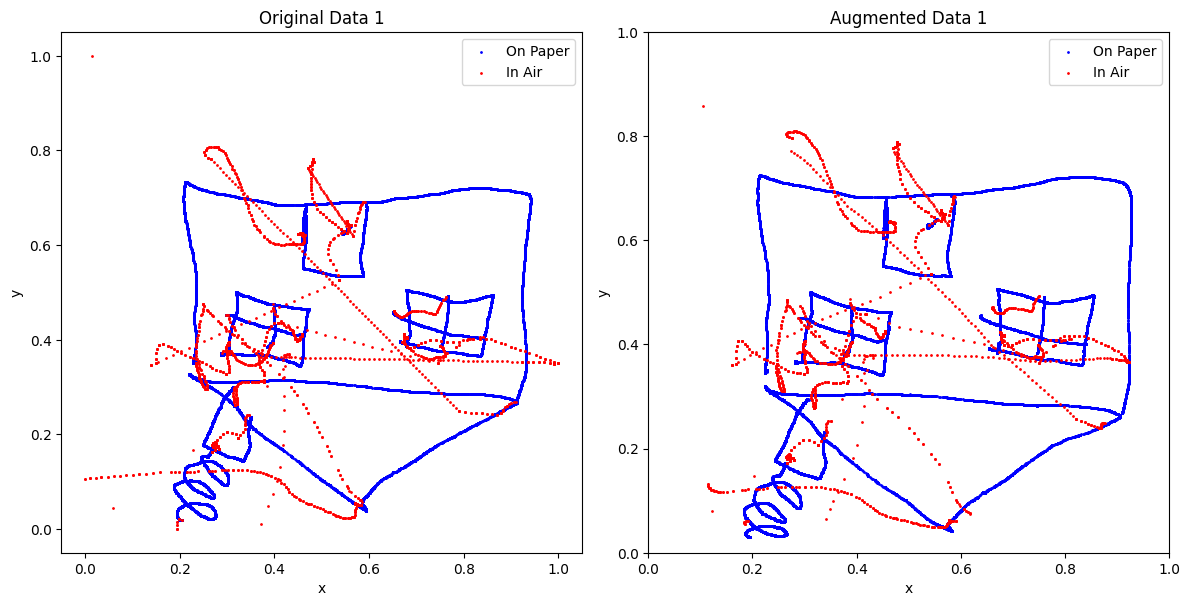

Epoch 13/200: 100%|██████████| 529/529 [00:02<00:00, 210.33batch/s, Generator Loss=3.75e-5, Reconstruction Loss=3.02e-5, KL Loss=7.31]  


Epoch 13: Generator Loss = 0.000079, Reconstruction Loss = 0.000072, KL Divergence Loss = 7.613452
NRMSE = 0.235553


Epoch 14/200: 100%|██████████| 529/529 [00:02<00:00, 217.86batch/s, Generator Loss=0.000208, Reconstruction Loss=0.0002, KL Loss=7.2]   


Epoch 14: Generator Loss = 0.000065, Reconstruction Loss = 0.000058, KL Divergence Loss = 7.446762
NRMSE = 0.236903


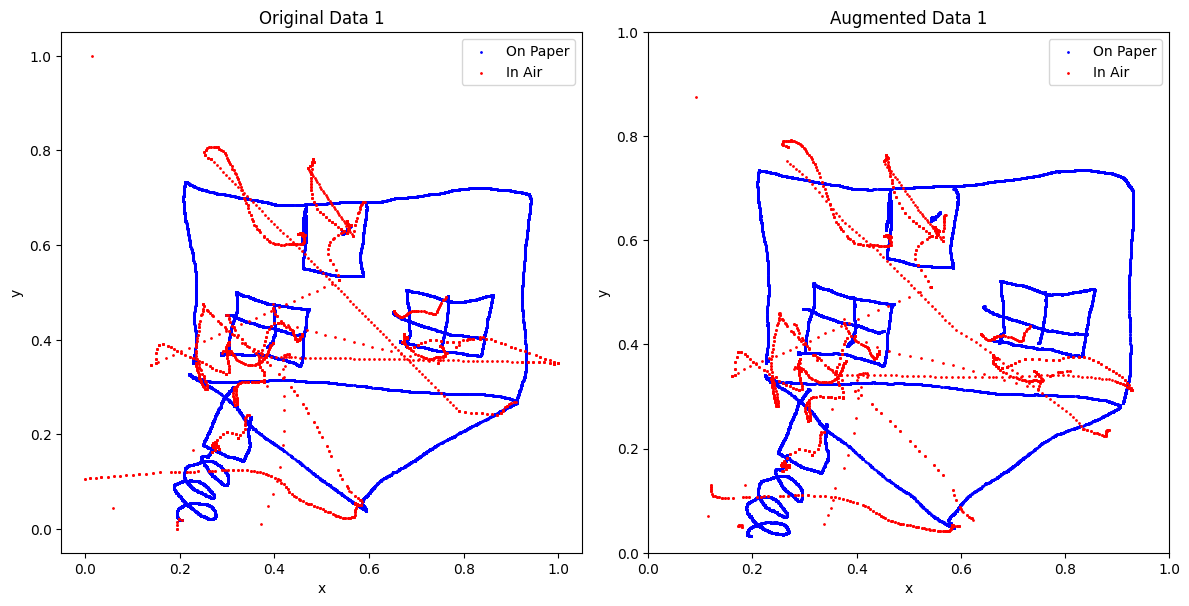

Epoch 15/200: 100%|██████████| 529/529 [00:02<00:00, 219.03batch/s, Generator Loss=0.000108, Reconstruction Loss=0.000101, KL Loss=6.97]


Epoch 15: Generator Loss = 0.000076, Reconstruction Loss = 0.000069, KL Divergence Loss = 7.209471
NRMSE = 0.238003


Epoch 16/200: 100%|██████████| 529/529 [00:02<00:00, 211.61batch/s, Generator Loss=4.8e-5, Reconstruction Loss=4.15e-5, KL Loss=6.51]   


Epoch 16: Generator Loss = 0.000064, Reconstruction Loss = 0.000057, KL Divergence Loss = 7.077743
NRMSE = 0.238772


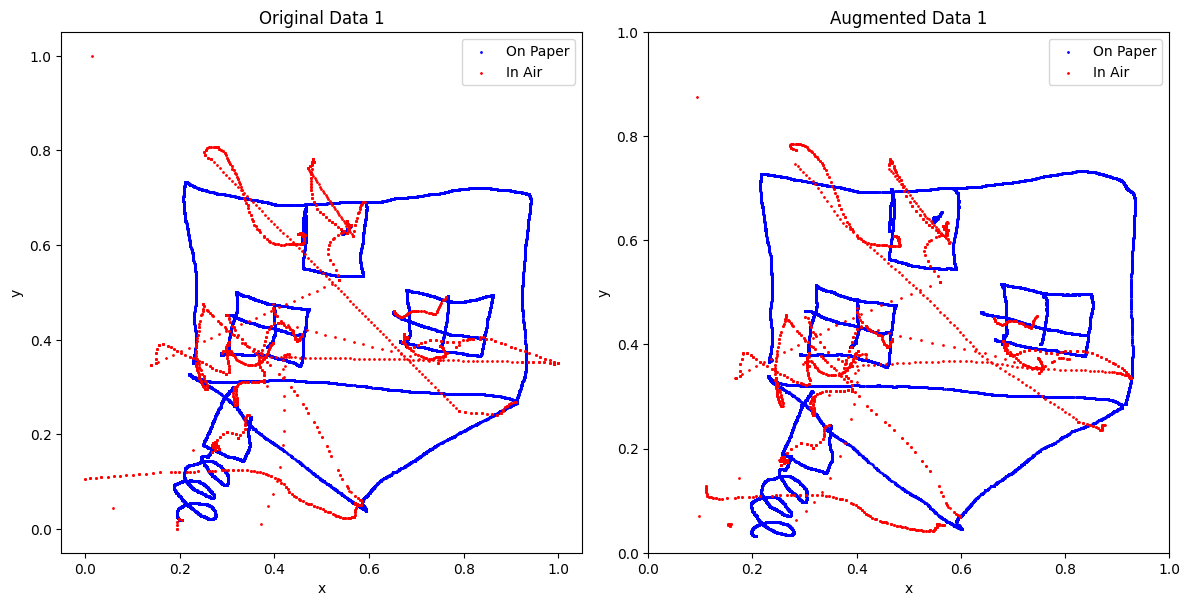

Epoch 17/200: 100%|██████████| 529/529 [00:02<00:00, 195.05batch/s, Generator Loss=5.38e-5, Reconstruction Loss=4.72e-5, KL Loss=6.56]  


Epoch 17: Generator Loss = 0.000050, Reconstruction Loss = 0.000043, KL Divergence Loss = 6.903056
NRMSE = 0.239251


Epoch 18/200: 100%|██████████| 529/529 [00:02<00:00, 178.12batch/s, Generator Loss=0.00015, Reconstruction Loss=0.000144, KL Loss=6.35] 


Epoch 18: Generator Loss = 0.000054, Reconstruction Loss = 0.000047, KL Divergence Loss = 6.767526
NRMSE = 0.239882


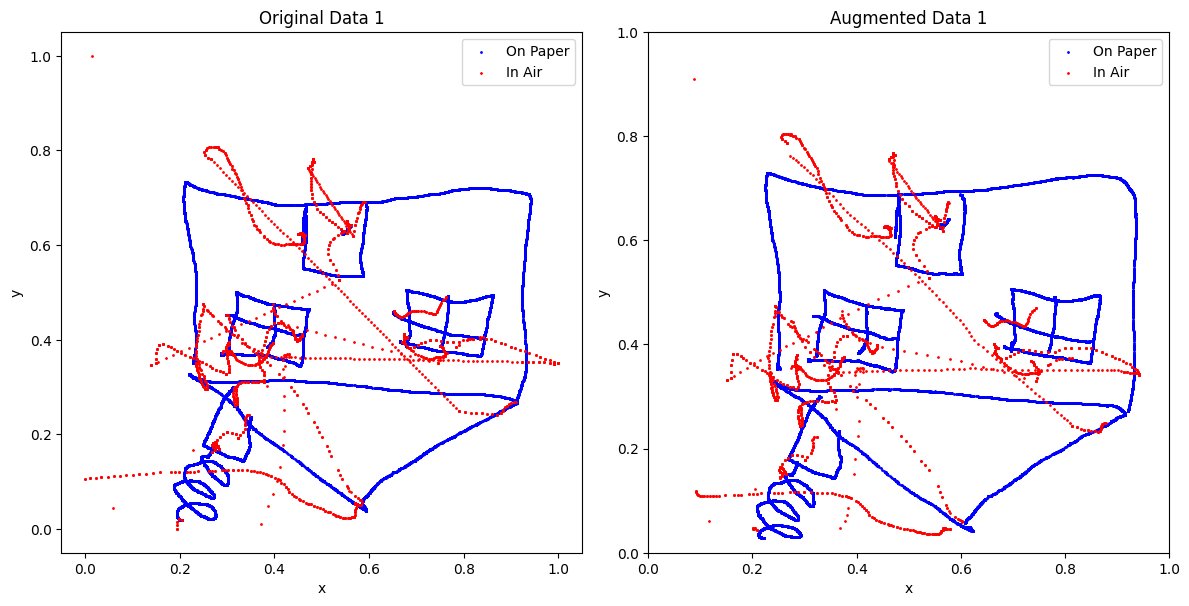

Epoch 19/200: 100%|██████████| 529/529 [00:02<00:00, 202.18batch/s, Generator Loss=3.96e-5, Reconstruction Loss=3.33e-5, KL Loss=6.34]  


Epoch 19: Generator Loss = 0.000051, Reconstruction Loss = 0.000045, KL Divergence Loss = 6.609354
NRMSE = 0.241175


Epoch 20/200: 100%|██████████| 529/529 [00:22<00:00, 23.44batch/s, Generator Loss=-0.139, Reconstruction Loss=0.000128, KL Loss=5.87]


LSTM training at epoch 20: Discriminator Loss = [1.2823805]
Epoch 20: Generator Loss = -0.138623, Reconstruction Loss = 0.000180, KL Divergence Loss = 6.212791
NRMSE = 0.241210


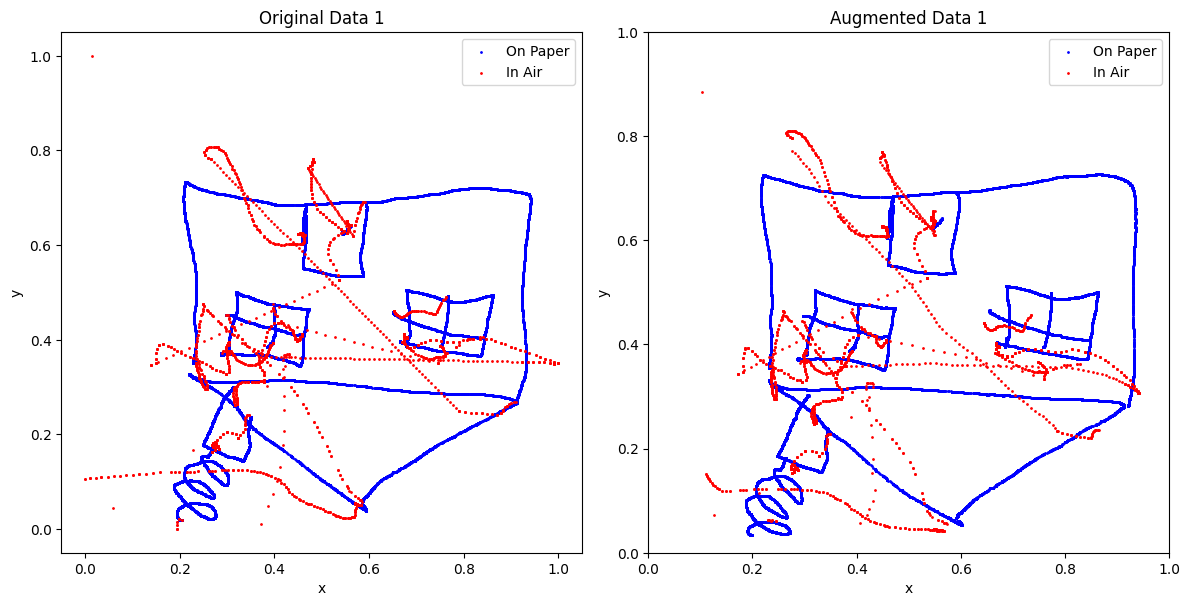

Epoch 21/200: 100%|██████████| 529/529 [00:02<00:00, 191.35batch/s, Generator Loss=3.53e-5, Reconstruction Loss=2.92e-5, KL Loss=6.04]  


Epoch 21: Generator Loss = 0.000034, Reconstruction Loss = 0.000028, KL Divergence Loss = 6.289094
NRMSE = 0.243062


Epoch 22/200: 100%|██████████| 529/529 [00:02<00:00, 223.20batch/s, Generator Loss=2.21e-5, Reconstruction Loss=1.63e-5, KL Loss=5.82]  


Epoch 22: Generator Loss = 0.000034, Reconstruction Loss = 0.000028, KL Divergence Loss = 6.243186
NRMSE = 0.243264


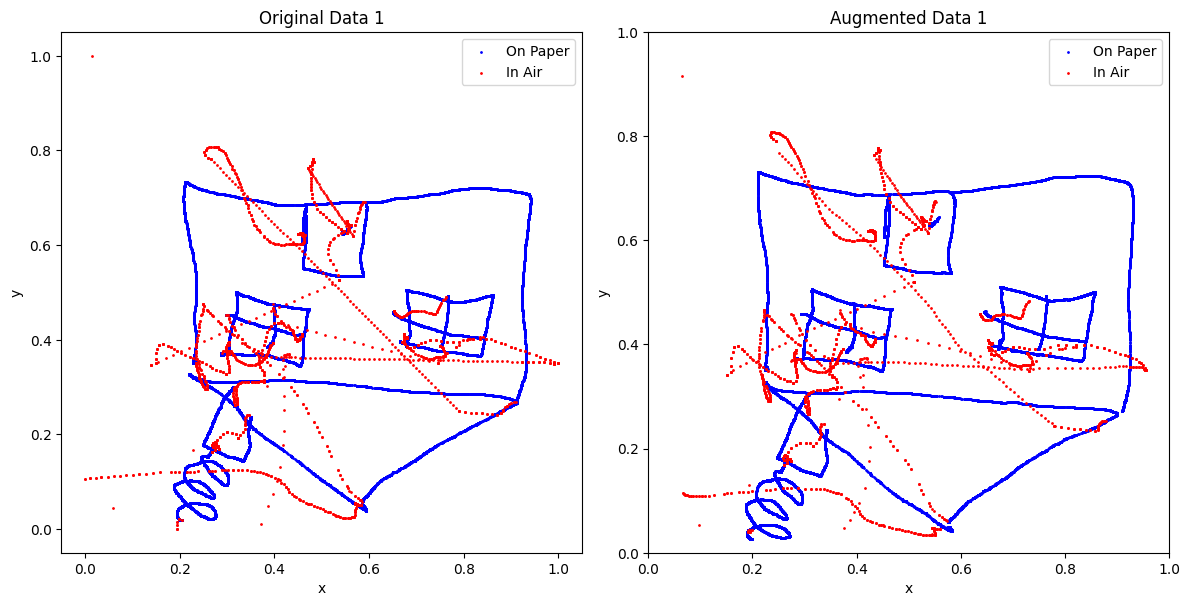

Epoch 23/200: 100%|██████████| 529/529 [00:02<00:00, 215.84batch/s, Generator Loss=2.15e-5, Reconstruction Loss=1.58e-5, KL Loss=5.73]  


Epoch 23: Generator Loss = 0.000056, Reconstruction Loss = 0.000050, KL Divergence Loss = 6.023399
NRMSE = 0.243862


Epoch 24/200: 100%|██████████| 529/529 [00:02<00:00, 217.57batch/s, Generator Loss=4.8e-5, Reconstruction Loss=4.22e-5, KL Loss=5.79]   


Epoch 24: Generator Loss = 0.000047, Reconstruction Loss = 0.000041, KL Divergence Loss = 5.985619
NRMSE = 0.245347


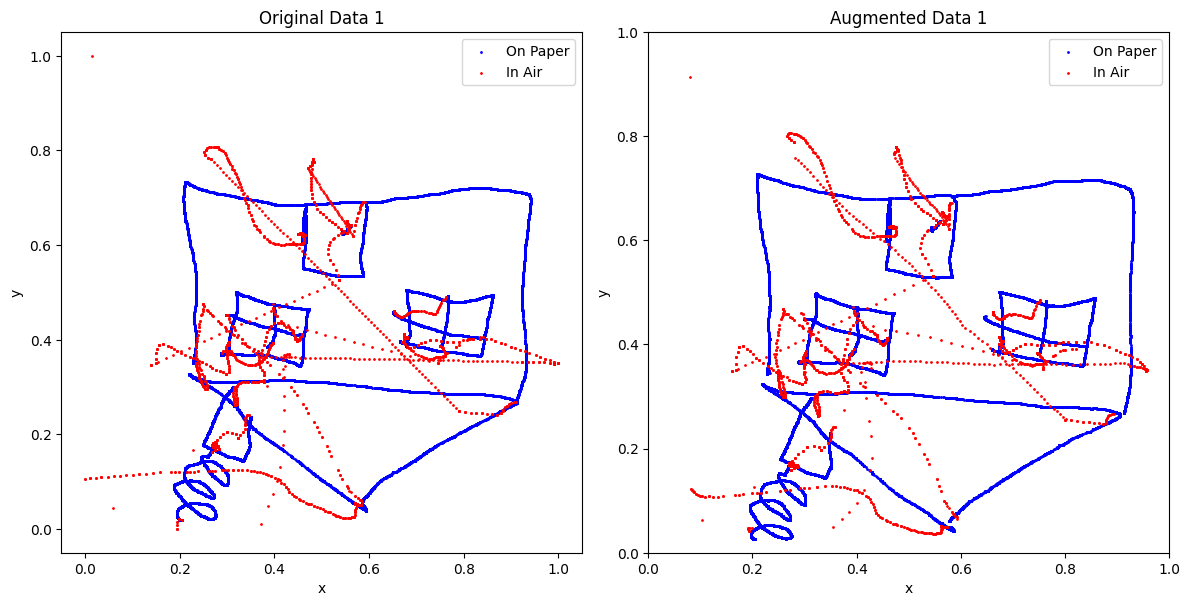

Epoch 25/200: 100%|██████████| 529/529 [00:03<00:00, 172.74batch/s, Generator Loss=3.53e-5, Reconstruction Loss=2.98e-5, KL Loss=5.53]  


Epoch 25: Generator Loss = 0.000040, Reconstruction Loss = 0.000034, KL Divergence Loss = 5.885811
NRMSE = 0.244929


Epoch 26/200: 100%|██████████| 529/529 [00:02<00:00, 195.70batch/s, Generator Loss=0.000102, Reconstruction Loss=9.68e-5, KL Loss=5.37] 


Epoch 26: Generator Loss = 0.000034, Reconstruction Loss = 0.000028, KL Divergence Loss = 5.811331
NRMSE = 0.245579


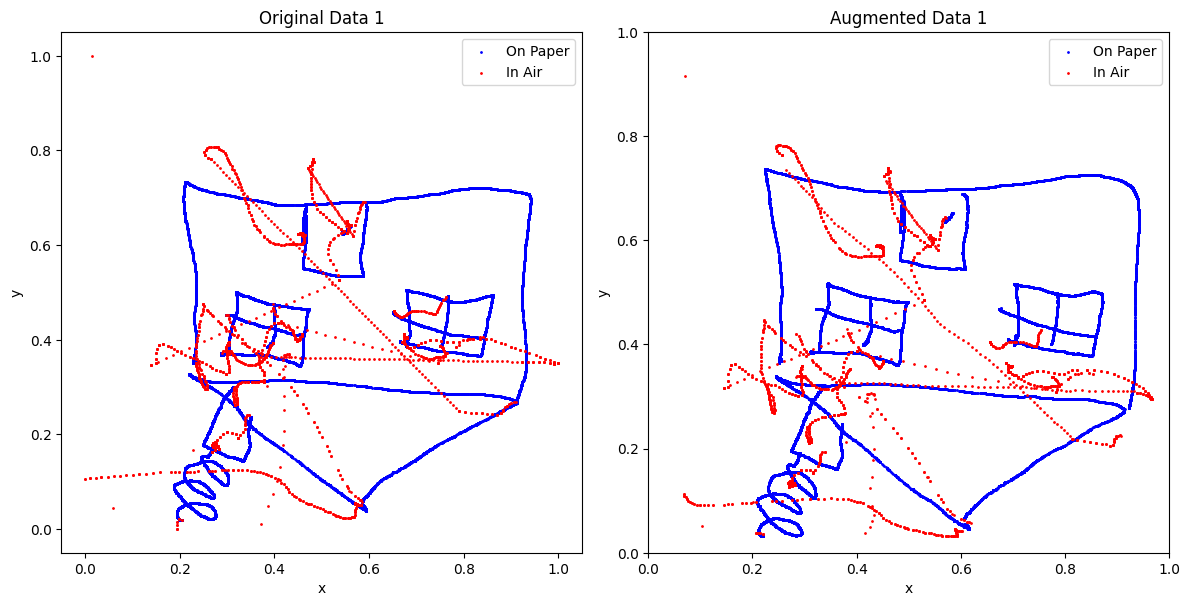

Epoch 27/200: 100%|██████████| 529/529 [00:02<00:00, 188.89batch/s, Generator Loss=7.21e-5, Reconstruction Loss=6.64e-5, KL Loss=5.7]   


Epoch 27: Generator Loss = 0.000039, Reconstruction Loss = 0.000033, KL Divergence Loss = 5.723576
NRMSE = 0.245775


Epoch 28/200: 100%|██████████| 529/529 [00:02<00:00, 216.97batch/s, Generator Loss=1.77e-5, Reconstruction Loss=1.25e-5, KL Loss=5.2]   


Epoch 28: Generator Loss = 0.000034, Reconstruction Loss = 0.000029, KL Divergence Loss = 5.627951
NRMSE = 0.247232


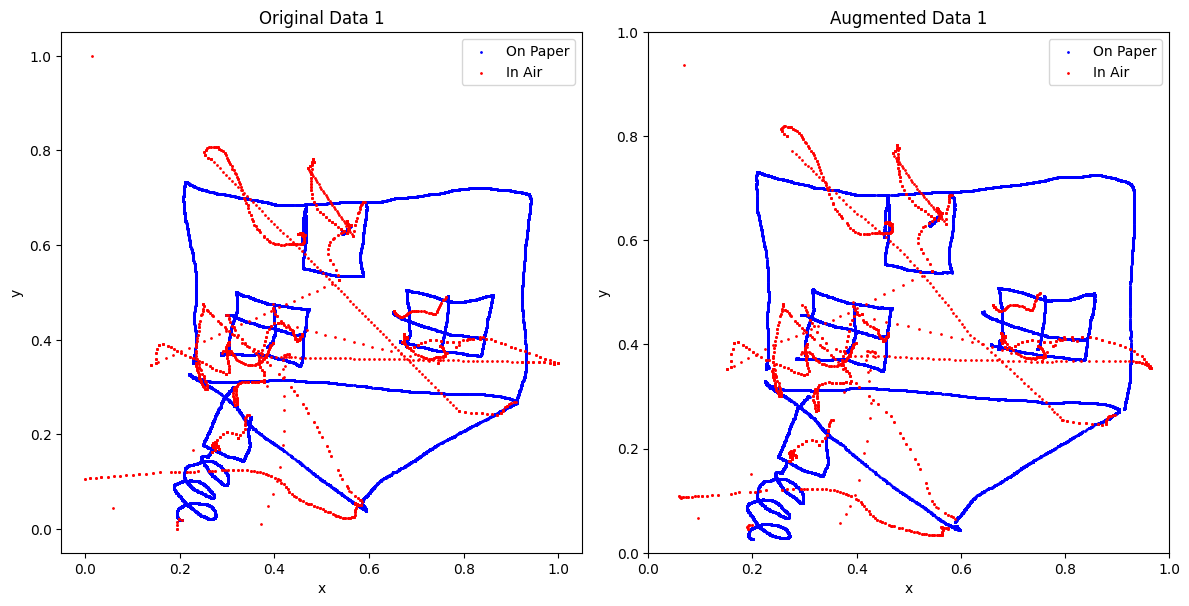

Epoch 29/200: 100%|██████████| 529/529 [00:02<00:00, 213.93batch/s, Generator Loss=9.26e-5, Reconstruction Loss=8.74e-5, KL Loss=5.21]  


Epoch 29: Generator Loss = 0.000034, Reconstruction Loss = 0.000029, KL Divergence Loss = 5.555922
NRMSE = 0.247460


Epoch 30/200: 100%|██████████| 529/529 [00:15<00:00, 34.92batch/s, Generator Loss=-0.139, Reconstruction Loss=0.000237, KL Loss=4.99]


In [ ]:
# Cell 5
@tf.function
def train_vae_step(model, x, optimizer, lstm_discriminator=None):
    with tf.GradientTape() as tape:
        x_reconstructed, mean, logvar = model(x)
        reconstruction_loss, kl_loss, total_kl_loss = compute_loss(model, x)
        
        # Add LSTM discriminator loss if available
        if lstm_discriminator is not None:
            real_predictions = lstm_discriminator(tf.expand_dims(x, axis=0))
            fake_predictions = lstm_discriminator(tf.expand_dims(x_reconstructed, axis=0))
            discriminator_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions) +
                                                tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_predictions), fake_predictions))
            generator_loss = reconstruction_loss + total_kl_loss - 0.1 * discriminator_loss  # Adjust the weight as needed
        else:
            generator_loss = reconstruction_loss + total_kl_loss
    
    gradients = tape.gradient(generator_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return generator_loss, reconstruction_loss, kl_loss

@tf.function
def train_lstm_step(lstm_model, real_data, generated_data, optimizer):
    with tf.GradientTape() as tape:
        real_predictions = lstm_model(real_data)
        generated_predictions = lstm_model(generated_data)
        real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions)
        generated_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(generated_predictions), generated_predictions)
        total_loss = real_loss + generated_loss
    gradients = tape.gradient(total_loss, lstm_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, lstm_model.trainable_variables))
    return total_loss

# Initialize LSTM discriminator and optimizer
lstm_discriminator = LSTMDiscriminator()
lstm_optimizer = tf.keras.optimizers.Adam(learning_rate)

batch_size = 64
train_datasets = [tf.data.Dataset.from_tensor_slices(data).shuffle(10000).batch(batch_size) for data in processed_data]

# Set up alternating epochs
vae_epochs = 19
lstm_interval = 10
epochs = 200

generator_loss_history = []
reconstruction_loss_history = []
kl_loss_history = []
nrmse_history = []

for epoch in range(epochs):
    generator_loss = 0 
    reconstruction_loss_sum = 0
    kl_loss_sum = 0
    num_batches = sum(len(dataset) for dataset in train_datasets)

    with tqdm(total=num_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for dataset in train_datasets:
            for batch in dataset:
                # Use LSTM discriminator after vae_epochs and every lstm_interval
                use_lstm = epoch >= vae_epochs and (epoch - vae_epochs) % lstm_interval == 0
                generator_loss_batch, reconstruction_loss, kl_loss = train_vae_step(vae, batch, optimizer, lstm_discriminator if use_lstm else None)
                generator_loss += generator_loss_batch
                reconstruction_loss_sum += reconstruction_loss
                kl_loss_sum += kl_loss
                pbar.update(1)
                pbar.set_postfix({'Generator Loss': float(generator_loss_batch), 'Reconstruction Loss': float(reconstruction_loss), 'KL Loss': float(kl_loss)})

    # Train the LSTM discriminator every lstm_interval epochs after vae_epochs
    if epoch >= vae_epochs and (epoch - vae_epochs) % lstm_interval == 0:
        for data in processed_data:
            augmented_data = vae.decode(tf.random.normal(shape=(data.shape[0], latent_dim))).numpy()
            real_data = tf.expand_dims(data, axis=0)  # Reshape for LSTM input
            generated_data = tf.expand_dims(augmented_data, axis=0)

            lstm_loss = train_lstm_step(lstm_discriminator, real_data, generated_data, lstm_optimizer)
        print(f'LSTM training at epoch {epoch+1}: Discriminator Loss = {lstm_loss.numpy()}')

    avg_generator_loss = generator_loss / num_batches  # Update the average calculation
    avg_reconstruction_loss = reconstruction_loss_sum / num_batches
    avg_kl_loss = kl_loss_sum / num_batches

    generator_loss_history.append(avg_generator_loss)  # Update history list
    reconstruction_loss_history.append(avg_reconstruction_loss)
    kl_loss_history.append(avg_kl_loss)

    # Calculate NRMSE
    nrmse_sum = 0
    for data in processed_data:
        augmented_data = vae.decode(tf.random.normal(shape=(data.shape[0], latent_dim))).numpy()
        rmse = np.sqrt(mean_squared_error(data[:, :2], augmented_data[:, :2]))
        nrmse = rmse / (data[:, :2].max() - data[:, :2].min())
        nrmse_sum += nrmse
    
    nrmse_avg = nrmse_sum / len(processed_data)

    nrmse_history.append(nrmse_avg)

    print(f"Epoch {epoch+1}: Generator Loss = {avg_generator_loss:.6f}, Reconstruction Loss = {avg_reconstruction_loss:.6f}, KL Divergence Loss = {avg_kl_loss:.6f}")
    print(f"NRMSE = {nrmse_avg:.6f}")

    if (epoch + 1) % 2 == 0:
        num_augmented_files = 1  # You can change this number as needed
        augmented_datasets = generate_augmented_data(vae, num_augmented_files, avg_data_points, processed_data, latent_variability=100.0)

        # Visualize the original and augmented data side by side
        fig, axs = plt.subplots(1, num_augmented_files + len(processed_data), figsize=(6*(num_augmented_files + len(processed_data)), 6))
        
        for i, original_data in enumerate(processed_data):
            original_on_paper = original_data[original_data[:, 3] == 1]
            original_in_air = original_data[original_data[:, 3] == 0]
            axs[i].scatter(original_on_paper[:, 0], original_on_paper[:, 1], c='b', s=1, label='On Paper')
            axs[i].scatter(original_in_air[:, 0], original_in_air[:, 1], c='r', s=1, label='In Air')
            axs[i].set_title(f'Original Data {i+1}')
            axs[i].set_xlabel('x')
            axs[i].set_ylabel('y')
            axs[i].set_aspect('equal')
            axs[i].legend()

        # Set consistent axis limits for square aspect ratio
        x_min = min(data[:, 0].min() for data in processed_data)
        x_max = max(data[:, 0].max() for data in processed_data)
        y_min = min(data[:, 1].min() for data in processed_data)
        y_max = max(data[:, 1].max() for data in processed_data)

        for i, augmented_data in enumerate(augmented_datasets):
            augmented_on_paper = augmented_data[augmented_data[:, 3] == 1]
            augmented_in_air = augmented_data[augmented_data[:, 3] == 0]
            axs[i+len(processed_data)].scatter(augmented_on_paper[:, 0], augmented_on_paper[:, 1], c='b', s=1, label='On Paper')
            axs[i+len(processed_data)].scatter(augmented_in_air[:, 0], augmented_in_air[:, 1], c='r', s=1, label='In Air')
            axs[i+len(processed_data)].set_title(f'Augmented Data {i+1}')
            axs[i+len(processed_data)].set_xlabel('x')
            axs[i+len(processed_data)].set_ylabel('y')
            axs[i+len(processed_data)].set_aspect('equal')
            axs[i+len(processed_data)].set_xlim(x_min, x_max)
            axs[i+len(processed_data)].set_ylim(y_min, y_max)
            axs[i+len(processed_data)].legend()

        plt.tight_layout()
        plt.show()

# Final output of metrics
print(f"Final NRMSE: {nrmse_history[-1]:.6f}")

print("Training completed.")
plt.ioff()  # Turn off interactive mode
plt.show()

# Plot generator loss history
plt.figure(figsize=(10, 5))
plt.plot(generator_loss_history, label='Generator Loss')  # Update label
plt.plot(reconstruction_loss_history, label='Reconstruction Loss')
plt.plot(kl_loss_history, label='KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Plot NRMSE history
plt.subplot(1, 3, 3)
plt.plot(nrmse_history, label='NRMSE')
plt.xlabel('Epoch')
plt.ylabel('NRMSE')
plt.title('Normalized Root Mean Squared Error Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Function to prepare data for predictive score
def prepare_predictive_data(combined_data, augmented_datasets):
    # Split real data into features (all except last time step) and target (last time step)
    X_real = combined_data[:, :-1]  # All except last time step
    y_real = combined_data[:, -1]   # Last time step

    # Split synthetic data into features and target
    X_synthetic = np.vstack([data[:, :-1] for data in augmented_datasets])  # All except last time step
    y_synthetic = np.hstack([data[:, -1] for data in augmented_datasets])   # Last time step

    return X_real, y_real, X_synthetic, y_synthetic

# Function to calculate Post-Hoc Predictive Score with MAPE
def post_hoc_predictive_score(combined_data, augmented_datasets):
    # Prepare the real and synthetic data for training and testing
    X_real, y_real, X_synthetic, y_synthetic = prepare_predictive_data(combined_data, augmented_datasets)

    # Normalize the feature data
    scaler = MinMaxScaler()
    X_real_scaled = scaler.fit_transform(X_real)
    X_synthetic_scaled = scaler.transform(X_synthetic)

    mapes = []  # List to store MAPE values

    # Train and evaluate the model multiple times for stability
    for _ in range(10):
        model = Sequential()  # Initialize the model
        model.add(Dense(50, input_dim=X_synthetic_scaled.shape[1], activation='relu'))  # Add a Dense layer
        model.add(Dense(1))  # Output layer

        # Compile the model
        model.compile(loss='mean_squared_error', optimizer='adam')
        # Train the model on synthetic data
        model.fit(X_synthetic_scaled, y_synthetic, epochs=10, batch_size=32, verbose=0)

        # Predict on real data
        y_pred = model.predict(X_real_scaled)
        # Calculate MAPE for the current iteration
        mape = mean_absolute_percentage_error(y_real, y_pred)
        mapes.append(mape)  # Append MAPE to the list

    # Calculate mean and standard deviation of MAPE values
    mean_mape = np.mean(mapes)
    std_mape = np.std(mapes)
    return mean_mape, std_mape

# Example usage (assuming combined_data and augmented_datasets are defined)
mean_mape, std_mape = post_hoc_predictive_score(combined_data, augmented_datasets)
# Print the calculated mean and standard deviation of MAPE
print(f"Mean MAPE: {mean_mape}, Std MAPE: {std_mape}")

In [ ]:
# Function to prepare data for LSTM
def prepare_lstm_data(combined_data, augmented_datasets):
    # Print the shape of the combined data and the number of augmented datasets
    print(f"Combined Data Shape: {combined_data.shape}")
    print(f"Augmented Datasets Length: {len(augmented_datasets)}")

    # Stack combined data and augmented datasets into a single array
    X = np.vstack([combined_data] + augmented_datasets)

    # Create labels: 0 for combined data, 1 for each augmented dataset
    y = np.hstack([np.zeros(len(combined_data))] + [np.ones(data.shape[0]) for data in augmented_datasets])

    return X, y

# Function to calculate Post-Hoc Discriminative Score with LSTM
def post_hoc_discriminative_score(combined_data, augmented_datasets):
    # Prepare the data for LSTM
    X, y = prepare_lstm_data(combined_data, augmented_datasets)

    # Initialize K-Fold cross-validation with 10 splits
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    accuracies = []  # List to store accuracy scores for each fold

    # Loop through each fold
    for train_index, test_index in kf.split(X):
        # Split the data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Reshape the data for LSTM input: (samples, time steps, features)
        X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

        # Build the LSTM model
        model = Sequential()
        model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))  # LSTM layer
        model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation for binary classification
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

        # Train the model
        model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

        # Predict on the test set
        y_pred = model.predict(X_test)
        y_pred_classes = np.where(y_pred > 0.5, 1, 0)  # Threshold predictions at 0.5 for binary classification

        # Calculate the accuracy for the current fold
        accuracy = accuracy_score(y_test, y_pred_classes)
        accuracies.append(accuracy)  # Append the accuracy to the list

    # Calculate the mean and standard deviation of the accuracy scores
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    return mean_accuracy, std_accuracy

# Example usage (assuming combined_data and augmented_datasets are defined)
mean_acc, std_acc = post_hoc_discriminative_score(combined_data, augmented_datasets)
# Print the calculated mean and standard deviation of accuracy
print(f"Mean Accuracy: {mean_acc}, Std Accuracy: {std_acc}")

In [54]:
# Cell 6
def download_augmented_data(augmented_datasets, scaler, directory='augmented_data'):
    if not os.path.exists(directory):
        os.makedirs(directory)

    for i, augmented_data in enumerate(augmented_datasets):
        augmented_data_original_scale = np.column_stack((
            scaler.inverse_transform(augmented_data[:, :3]),  # Inverse scale x, y, timestamp
            augmented_data[:, 3]  # Keep pen_status unchanged
        ))

        # Save each augmented dataset to a CSV file
        filename = os.path.join(directory, f'augmented_data_{i+1}.csv')
        pd.DataFrame(augmented_data_original_scale, columns=['x', 'y', 'timestamp', 'pen_status']).to_csv(filename, index=False)
        print(f"Saved {filename}")

# Call the updated function with the same scaler for all augmented datasets
download_augmented_data(augmented_datasets, scalers[0])


Saved augmented_data\augmented_data_1.csv


In [55]:
#Cell 7 Function to visualize the latent space with a color gradient
def visualize_latent_space(model, data, perplexity=5, learning_rate=200, n_iter=250):
    # Encode data into the latent space
    latent_means, _ = model.encode(tf.convert_to_tensor(data, dtype=tf.float32))
    latent_means_np = latent_means.numpy()
    
    # Use t-SNE to reduce dimensionality to 2D
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter)
    latent_2d = tsne.fit_transform(latent_means_np)
    
    # Create a color map for the latent points
    norm = plt.Normalize(vmin=np.min(latent_means_np), vmax=np.max(latent_means_np))
    cmap = plt.cm.cividis  # You can change the colormap to 'plasma', 'inferno', etc.
    colors = cmap(norm(latent_means_np).sum(axis=1))  # Coloring based on the sum of latent variables
    
    # Plot the 2D t-SNE result with the color map
    plt.figure(figsize=(16, 12))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=colors, s=5, alpha=0.6)
    plt.colorbar(scatter)  # Add a color bar for the gradient
    plt.title('Latent Space Visualization using t-SNE')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True)
    plt.show()

# Visualize latent space for one of the processed datasets
visualize_latent_space(vae, processed_data[0])

NameError: name 'TSNE' is not defined